In [83]:
from math import sin, cos, pi
import numpy as np
from scipy.optimize import minimize
from mpl_toolkits.mplot3d import Axes3D  # Use the correct import
import matplotlib.pyplot as plt
import pandas as pd
from scipy.integrate import quad
from scipy.spatial.transform import Rotation as R

Parameters:

LT -> Local Time (hours)  
del_T_utc -> Difference between Local Time (LT) and Universal Coordinated Time (UTC) (hours)  
d -> No. of days from the start of they year  
La -> Latitude (deg)  
Lo -> Longitude (deg)  
G -> Solar Intensity (W/m^2)  

In [84]:
LT = 15
del_T_utc = 9.5
d = 231
La = -23.68                  # 23.68
Lo = 133.87
G = 1360
LT_start = 5
LT_stop = 17

Calculating other Parameters:  

B -> something  
LSTM -> Local Standard Time Meridian (deg)  
EoT -> Equation of Time (min)  
TC -> Time Correction Factor (min)  
LST -> Local Solar Time (hours)  
HRA -> Hour Angle (deg)  
Dec -> Declination Angle (deg)  

In [85]:
B = 360 * (d - 81) / 365
LSTM = 15 * del_T_utc
EoT = 9.87 * sin(pi/180 * 2*B) - 7.53 * cos(pi/180 * B) - 1.5 * sin(pi/180 * B)
TC = 4 * (Lo - LSTM) + EoT
LST = LT + TC/60
HRA = 15 * (LST - 12)
HRA_curr = HRA
Dec = -23.45 * cos(2*pi * (d + 10) / 365)
HRA_start = 15 * (LT_start + TC/60 - 12)
HRA_stop = 15 * (LT_stop + TC/60 - 12)
def LT_to_HRA(LT_):
    B_ = 360 * (d - 81) / 365
    LSTM_ = 15 * del_T_utc
    EoT_ = 9.87 * sin(pi/180 * 2*B_) - 7.53 * cos(pi/180 * B_) - 1.5 * sin(pi/180 * B_)
    TC_ = 4 * (Lo - LSTM_) + EoT_
    LST_ = LT_ + TC_/60
    HRA_ = 15 * (LST_ - 12)
    return HRA_

Function for Power (W)  

Beta -> Angle of Plane of Panel with Horizontal (deg) = (normal w vertical)?   
Gamma -> Azimuth Angle (deg)  
A -> Area of Panel

In [86]:
def Power(A, beta, gamma, time=LT):

    HRA_curr = LT_to_HRA(time)
    
    Dec_r, beta_r, gamma_r, La_r, HRA_r = map(np.radians, (Dec, beta, gamma, La, HRA_curr))

    theta = np.arccos(np.sin(Dec_r)*np.sin(La_r)*np.cos(beta_r) - np.sin(Dec_r)*np.cos(La_r)*np.sin(beta_r)*np.cos(gamma_r) +
                      np.cos(Dec_r)*np.cos(La_r)*np.cos(beta_r)*np.cos(HRA_r) + np.cos(Dec_r)*np.sin(La_r)*np.sin(beta_r)*np.cos(gamma_r)*np.cos(HRA_r) +
                      np.cos(Dec_r)*np.sin(beta_r)*np.sin(gamma_r)*np.sin(HRA_r))
    power = G * A * np.cos(theta)
    return power

print(Power(6, 0, 0))

5224.402671288308


Energy over 2 given times (Wh)

In [87]:
def Energy(A, beta, gamma, t1=LT_start, t2=LT_stop):
    energy, error = quad(lambda t, a, b, g: Power(a, b, g, t), t1, t2, args=(A, beta, gamma))
    return energy

print(Energy(6, 0, 0))

42197.39637826134


In [88]:
# Analytical function to output Total Energy(J) (given in primer)
def Energy_(A, beta, gamma):
  Dec_r, beta_r, gamma_r, La_r, HRA_start_r, HRA_stop_r = map(np.radians, (Dec, beta, gamma, La, HRA_start, HRA_stop))

  energy_ = 43200 * G / pi * (np.cos(La_r)*np.cos(Dec_r)*(np.sin(HRA_stop_r) - np.sin(HRA_start_r)) +
                             (HRA_stop_r - HRA_start_r)/180*np.sin(La_r)*np.sin(Dec_r))
  return energy_ * A

print(Energy_(6, 0, 0))

182458086.49449065


Plot of angle of Panel vs Power

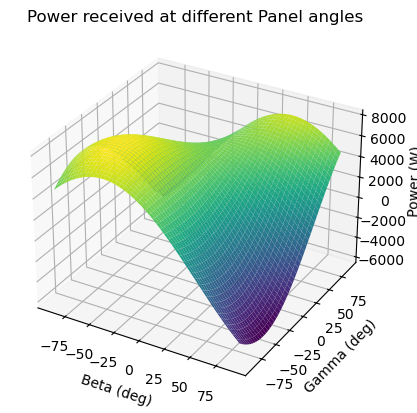

In [89]:
# 3-D projection
ax = plt.axes(projection='3d')

# Defining all 3 axes
beta = np.linspace(-90, 90, 1800)
gamma = np.linspace(-90, 90, 1800)
Beta, Gamma = np.meshgrid(beta, gamma)

# Calculate power over the meshgrid
power_mesh = Power(6, Beta, Gamma)

# Plotting
ax.plot_surface(Beta, Gamma, power_mesh, cmap='viridis')
ax.set_title('Power received at different Panel angles')
ax.set_xlabel('Beta (deg)')
ax.set_ylabel('Gamma (deg)')
ax.set_zlabel('Power (W)')
plt.show()

Plot of angle of panel vs Energy

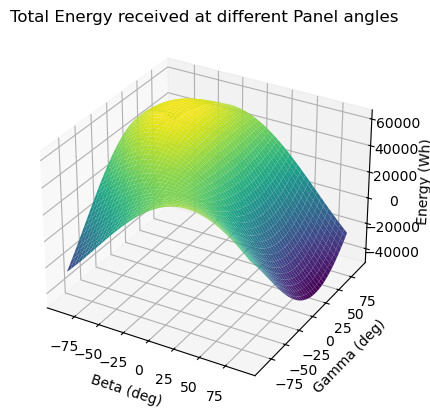

In [90]:
beta = np.linspace(-90, 90, 180)
gamma = np.linspace(-90, 90, 180)
Beta, Gamma = np.meshgrid(beta, gamma)

energy_mesh = np.zeros_like(Beta)

A = 6
for i in range(Beta.shape[0]):
    for j in range(Beta.shape[1]):
        energy_mesh[i, j], _ = quad(lambda t: Power(A, Beta[i, j], Gamma[i, j], t), LT_start, LT_stop)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(Beta, Gamma, energy_mesh, cmap='viridis')

ax.set_title('Total Energy received at different Panel angles')
ax.set_xlabel('Beta (deg)')
ax.set_ylabel('Gamma (deg)')
ax.set_zlabel('Energy (Wh)')
plt.show()


Calc. max Power and Corresponding Angle

In [91]:
# Numerically calculating
A = 6
def neg_Power(vars, A):
    x, y = vars
    return -Power(A, x, y)

initial_guess = [0, 0]
result = minimize(lambda vars: neg_Power(vars, A), initial_guess)

max_x, max_y = result.x
max_val = Power(A, max_x, max_y)
print(max_x, max_y, max_val)

-50.189870556083264 -47.62842217780428 8159.999999999942


In [92]:
# Analytically calculating
Dec_r, La_r, HRA_start_r, HRA_stop_r, HRA_r = map(np.radians, (Dec, La, HRA_start, HRA_stop, HRA))

alpha_sun_r = np.arcsin(np.cos(La_r)*np.cos(Dec_r)*np.cos(HRA_r) + np.sin(La_r)*np.sin(Dec_r))

gamma_sun_r = np.arccos((np.sin(alpha_sun_r)*np.sin(La_r) - np.sin(Dec_r)) / (np.cos(alpha_sun_r)*np.cos(La_r)))

beta_sun_r = pi/2 - alpha_sun_r

print("beta, gamma (for max power): ", beta_sun_r*180/pi, gamma_sun_r*180/pi)
print("corresponding Power: ", Power(6,beta_sun_r*180/pi, gamma_sun_r*180/pi))

beta, gamma (for max power):  50.18987731160846 132.37157610450905
corresponding Power:  8160.0


Calc. max Energy and Corresponding Angle

In [93]:
A = 6
def neg_Energy(vars, A):
    x, y = vars
    return -Energy(A, x, y)

initial_guess = [0, 0]
result = minimize(lambda vars: neg_Energy(vars, A), initial_guess)

max_x, max_y = result.x
max_val = Energy(A, max_x, max_y)
print(max_x, max_y, max_val)

-49.10457657687693 31.132594294732304 64454.95277228909


Integrating over Array  
Sitting at the drivers seat,  
z - forward  
y - up  
x - left  

In [94]:
df1 = pd.read_csv('.\locations_set.csv')
df2 = pd.read_csv('.\\normals_set.csv')
df3 = pd.read_csv('.\\areas_set.csv')
df = pd.concat([df1, df2, df3], axis=1)
df

,x_loc,y_loc,z_loc,x_comp,y_comp,z_comp,area
0,426.558750,520.93590,-4012.2520,0.000217,-0.994090,0.108559,1216.623535
1,465.577150,566.39075,-3563.6067,-0.000036,-0.995762,0.091963,898.440369
2,547.429900,646.84690,-2081.3796,-0.000839,-0.999979,0.006385,1337.525879
3,47.330715,594.14350,-3238.9397,-0.000072,-0.996981,0.077651,175.526825
4,342.340600,554.10580,-3692.5000,-0.000294,-0.995260,0.097249,1442.245361
...,...,...,...,...,...,...,...
4423,-10.133422,508.49097,-4124.3647,-0.000306,-0.993707,0.112013,765.454773
4424,-27.877207,506.09457,-4145.5854,0.000109,-0.993650,0.112517,871.459167
4425,-21.133797,511.17236,-4100.5083,0.000257,-0.993782,0.111344,749.101440
4426,-669.423300,478.65552,-4380.8220,0.000192,-0.992916,0.118822,870.442261


In [95]:
def freqplot(df, column):
    plt.figure(figsize=(5, 3))
    df[column].plot(kind='hist', bins=40, edgecolor='black', color='skyblue', title=f'Frequency Distribution of {column}')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

Sanity check of data

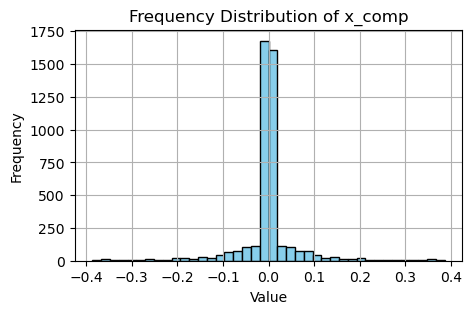

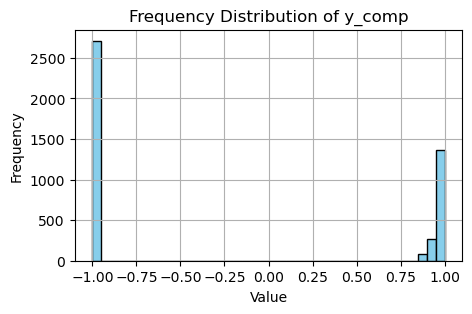

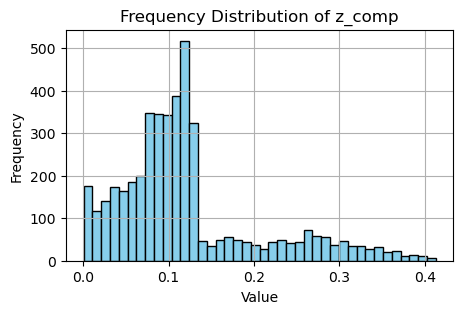

In [96]:
freqplot(df, 'x_comp')

freqplot(df, 'y_comp')

freqplot(df, 'z_comp')

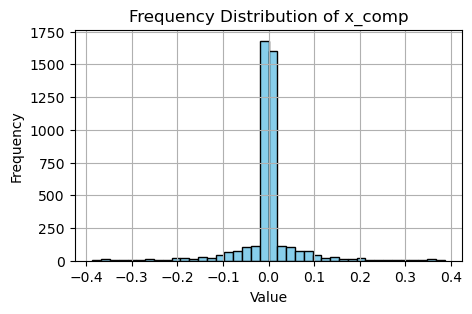

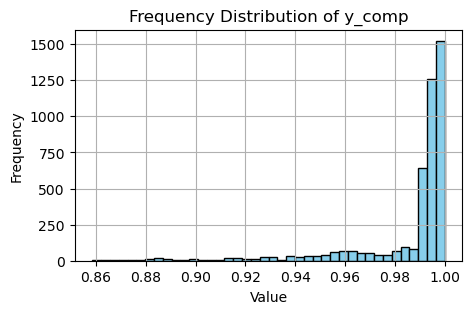

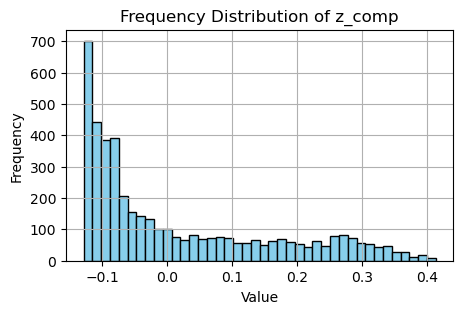

In [97]:
df_new = df[['x_comp', 'y_comp', 'z_comp']]
df_new = df_new.apply(lambda row: -row if row['y_comp'] < 0 else row, axis=1)
df_new['area'] = df['area']

freqplot(df_new, 'x_comp')

freqplot(df_new, 'y_comp')

freqplot(df_new, 'z_comp')

Direction of the car

In [100]:
cardinal_angle = 151                # Degrees (clockwise of north)
elevation_angle = 0                 # Degrees (tilting up)
cardinal_angle_r, elevation_angle_r = map(np.radians, (cardinal_angle, elevation_angle))
rotation_x = R.from_euler('x', -elevation_angle_r)
rotation_y = R.from_euler('y', -cardinal_angle_r)
net_rotation = rotation_y * rotation_x      # first about x then about y

In [101]:
total_power = 0
total_area = 0
total_energy = 0

for x_buf,y_buf,z_buf,a in zip(-df['x_comp'],-df['y_comp'],-df['z_comp'],df['area']):
    if y_buf < 0:
        x_buf, y_buf, z_buf = -x_buf, -y_buf, -z_buf
    x, y, z = net_rotation.apply(np.array([x_buf, y_buf, z_buf]))
    beta_ = np.degrees(-np.arccos(y))
    gamma_ = np.degrees(np.arctan2(x, z))
    a = a/1000000
    total_power += Power(a, beta_, gamma_)
    total_area += a
    ene, error = quad(lambda t, a, b, g: Power(a, b, g, t), LT_start, LT_stop, args=(a, beta_, gamma_))
    total_energy += ene

print('total power:', total_power)
print("total area:", total_area)
print('total energy:', total_energy)

total power: 4283.392036688432
total area: 4.966700631408692
total energy: 34799.35140121449
